In [12]:
%matplotlib inline

import conllu
import pandas as pd
import numpy as np
import spacy
import en_core_web_lg
import collections
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, make_scorer, precision_recall_fscore_support
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from tqdm import tqdm

In [2]:
nlp = en_core_web_lg.load()

## Part 1

### Loading data

In [17]:
train = conllu.parse(open("uk_iu-ud-train.conllu").read())
test = conllu.parse(open("uk_iu-ud-test.conllu").read())
dev = conllu.parse(open("uk_iu-ud-dev.conllu").read())

function for printing dep tree in form of tuples:

In [102]:
def print_tree(tree):
    for token in tree:
        print( token['form'], '<-', tree[token['head']-1]['form'] if token['head'] > 0 else 'root')
print_tree(train[0])

У <- домі
домі <- була
римського <- патриція
патриція <- домі
Руфіна <- патриція
була <- root
прегарна <- фреска
фреска <- була
, <- зображення
зображення <- фреска
Венери <- зображення
та <- Адоніса
Адоніса <- Венери
. <- була


### Writing basic oracle using static oracle

Simple static eager oracle:

In [101]:
def predict_action(stack, queue, relations):
    if stack and not queue:
        return 'reduce'
    elif stack[-1]['head'] == queue[0]['id']:
        return 'left_arc'
    elif stack[-1]['id'] == queue[0]['head']:
        return 'right_arc'
    elif stack[-1]['id'] in [r[0] for r in relations] and \
         queue[0]['head'] < stack[-1]['id']:
        return 'reduce'
    else:
        return 'shift'

In [20]:
ROOT = collections.OrderedDict([('id', 0), ('head', None), ('form', 'ROOT'), ('lemma', 'ROOT'), ('upostag', 'ROOT')])

I've started with extracting all features for 2 top elements from stack and 4 top elements from queue

In [103]:
def extract_features(stack, queue):
    features = {}
    if stack:
        features['s0form'] = stack[-1]['form']
        features['s0lemma'] = stack[-1]['lemma']
        features['s0pos'] = stack[-1]['upostag']
    if len(stack) > 1:
        features['s1form'] = stack[-2]['form']
        features['s1lemma'] = stack[-2]['lemma']
        features['s1pos'] = stack[-2]['upostag']
    if queue:
        features['q0form'] = queue[0]['form']
        features['q0lemma'] = queue[0]['lemma']
        features['q0pos'] = queue[0]['upostag']
    if len(queue) > 1:
        features['q1form'] = queue[1]['form']
        features['q1lemma'] = queue[1]['lemma']
        features['q1pos'] = queue[1]['upostag']
    if len(queue) > 2:
        features['q2form'] = queue[2]['form']
        features['q2lemma'] = queue[2]['lemma']
        features['q2pos'] = queue[2]['upostag']
    if len(queue) > 3:
        features['q3form'] = queue[3]['form']
        features['q3lemma'] = queue[3]['lemma']
        features['q3pos'] = queue[3]['upostag']
    if queue and stack:
        features['dist'] = queue[0]['id'] - stack[-1]['id']
        
    return features

Function for generating features, labels and relations by applying actions from static oracle:

In [22]:
def get_labels_features_relations(trees, verbose=False):
    labels, feats, rels = [], [], []
    for tree in trees:
        stack = [ROOT]
        queue = tree[:]
        relations = []
        i = 0
        while queue or stack:
            action = predict_action(stack, queue, relations)
            features = extract_features(stack, queue)
            labels.append(action)
            feats.append(features)
            if verbose:
                print('\n=========')
                print("Action: ", action)
                print('Stack: ', [el['form'] for el in stack])
                print('Queue:', [el['form'] for el in queue])
                print('Rels:', [(tree[el[0]-1]['form'], tree[el[1]-1]['form']) for el in relations])
            if action == 'reduce':
                stack.pop()
            elif action == 'shift':
                stack.append(queue.pop(0))
            elif action == 'left_arc':
                relations.append((stack[-1]['id'], queue[0]['id']))
                stack.pop()
            elif action == 'right_arc':
                relations.append((queue[0]['id'], stack[-1]['id']))
                stack.append(queue.pop(0))
            i += 1
            if i > 50:
                break
        if verbose:
            print("== Golden: ")
            print_tree(tree)
            print("== Predicted: ")
            [print(tree[c-1]['form'], '<--', tree[h-1]['form']) for c,h in relations]
        rels.append(relations)
    return (labels, feats, rels)

res = get_labels_features_relations([train[0]], verbose=True)


Action:  shift
Stack:  ['ROOT']
Queue: ['У', 'домі', 'римського', 'патриція', 'Руфіна', 'була', 'прегарна', 'фреска', ',', 'зображення', 'Венери', 'та', 'Адоніса', '.']
Rels: []

Action:  left_arc
Stack:  ['ROOT', 'У']
Queue: ['домі', 'римського', 'патриція', 'Руфіна', 'була', 'прегарна', 'фреска', ',', 'зображення', 'Венери', 'та', 'Адоніса', '.']
Rels: []

Action:  shift
Stack:  ['ROOT']
Queue: ['домі', 'римського', 'патриція', 'Руфіна', 'була', 'прегарна', 'фреска', ',', 'зображення', 'Венери', 'та', 'Адоніса', '.']
Rels: [('У', 'домі')]

Action:  shift
Stack:  ['ROOT', 'домі']
Queue: ['римського', 'патриція', 'Руфіна', 'була', 'прегарна', 'фреска', ',', 'зображення', 'Венери', 'та', 'Адоніса', '.']
Rels: [('У', 'домі')]

Action:  left_arc
Stack:  ['ROOT', 'домі', 'римського']
Queue: ['патриція', 'Руфіна', 'була', 'прегарна', 'фреска', ',', 'зображення', 'Венери', 'та', 'Адоніса', '.']
Rels: [('У', 'домі')]

Action:  right_arc
Stack:  ['ROOT', 'домі']
Queue: ['патриція', 'Руфіна', 

#### Metrics

This function parses sentences in conllu format into the dependencies, we will use it for evaluating UAS metric:

In [33]:
def parse_tree(oracle, trees, verbose=False):
    all_rels = []
    for tree in trees:
        stack = [ROOT]
        queue = tree[:]
        relations = []
        i = 0
        while stack or queue:
            features = extract_features(stack, queue)
            [action] = oracle.predict([features])
            if verbose:
                print('\n=========')
                print("Action: ", action)
                print('Stack: ', [el['form'] for el in stack])
                print('Queue:', [el['form'] for el in queue])
                print('Rels:', [(tree[el[0]-1]['form'], tree[el[1]-1]['form']) for el in relations])
            if not stack and queue:
                stack.append(queue.pop(0))
            elif stack and not queue:
                stack.pop()
            elif action == 'reduce':
                stack.pop()
            elif action == 'shift':
                stack.append(queue.pop(0))
            elif action == 'left_arc':
                relations.append((stack[-1]['id'], queue[0]['id']))
                stack.pop()
            elif action == 'right_arc':
                relations.append((queue[0]['id'], stack[-1]['id']))
                stack.append(queue.pop(0))
            i += 1
            if i > 50:
                break
        if verbose:
            print("== Golden: ")
            print_tree(tree)
            print("== Predicted: ")
            [print(tree[c-1]['form'], '<--', tree[h-1]['form']) for c,h in relations]
        all_rels.append(relations)
    return all_rels

Functions for evaluating UAS metric:

In [34]:
def tree_uas(true_tree, pred_tree):
    ts = set(true_tree)
    ps = set(pred_tree)
    return len(ts & ps),len(true_tree)

def trees_uas(true_trees, pred_trees):
    valid = 0
    total = 0
    for i in range(len(true_trees)):
        tp, tot = tree_uas(true_trees[i], pred_trees[i])
        valid += tp
        total += tot
    return valid/total

def uas(trees, oracle):
    cv_true_rels = [[(node['id'], node['head']) for node in tree] for tree in trees]
    cv_pred_rels = parse_tree(oracle, trees)
    return trees_uas(cv_true_rels, cv_pred_rels)

trees_uas([[(2,1), (1, 0), (3, 2)]],
          [[(1,2), (1, 0), (2, 3)]])

0.3333333333333333

This functions trains and measures performance of classifier on test and dev sets:

In [104]:
def evaluate(pipe, train_X, train_y, train_raw, cv_X, cv_y, cv_raw, verbose=True):
    pipe.fit(train_X, train_y)
    train_pred = pipe.predict(train_X)
    train_uas = uas(train_raw, pipe)
    trprec,trrecall,trfscore,_ = precision_recall_fscore_support(train_y, train_pred, average='weighted')
    if verbose:
        print("Train results") 
        print('precision:\t{}\nrecall:\t\t{}\nfscore:\t\t{}'.format(trprec, trrecall, trfscore))
        print("UAS:\t\t", train_uas)
    cv_pred = pipe.predict(cv_X)
    cv_uas = uas(cv_raw, pipe)
    cvprec, cvrecall, cvfscore, _ = precision_recall_fscore_support(cv_y, cv_pred, average='weighted')
    if verbose:
        print("CV results")  
        print('precision:\t{}\nrecall:\t\t{}\nfscore:\t\t{}'.format(cvprec, cvrecall, cvfscore))
        print("UAS:\t\t", cv_uas)
    return {
        'train_precision': trprec,
        'train_recall': trrecall,
        'train_fscore': trfscore,
        'train_uas': train_uas,
        'cv_precision': cvprec,
        'cv_recall': cvrecall,
        'cv_fscore': cvfscore,
        'cv_uas': cv_uas
    }

#### Collecting features

In [105]:
def get_all_features(examples):
    labels, features, _ = get_labels_features_relations(examples)
    return labels, features
ls,fs = get_all_features(train)
cv_ls, cv_fs = get_all_features(dev)
print("Labels: ", len(ls))
print("Examples: ", len(fs))

Labels:  134597
Examples:  134597


Let's start with dummy LogisticRegression and see results on train and test sets:

In [106]:
pipe = Pipeline([
    ('vectorizer', DictVectorizer()),
    ('classifier', LogisticRegression())
])

#cv_res = cross_validate(pipe, fs, y=ls, return_train_score=False)
evaluate(pipe, fs, ls, train, cv_fs, cv_ls, dev)
print("Test results: ")
print(classification_report(tls, pipe.predict(tfs)))
print("Test uas: ", uas(test, pipe))

Train results
precision:	0.9665617904203923
recall:		0.9663588341493495
fscore:		0.9663901518154907
UAS:		 0.8137899810913739
CV results
precision:	0.8253062685976025
recall:		0.8235803605261733
fscore:		0.8236938498111087
UAS:		 0.6090058817857488
Test results: 
             precision    recall  f1-score   support

   left_arc       0.84      0.86      0.85      6270
     reduce       0.85      0.75      0.79      5957
  right_arc       0.74      0.78      0.76      5853
      shift       0.83      0.85      0.84      6709

avg / total       0.81      0.81      0.81     24789

Test uas:  0.5593413213735859


### Improvements

#### Regularization
Lets try to play with regularization

In [114]:
results = {}
for C in tqdm([0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]):
    pipe = Pipeline([
        ('vectorizer', DictVectorizer()),
        ('classifier', LogisticRegression(C=C))
    ])
    metrics = evaluate(pipe, fs, ls, train, cv_fs, cv_ls, dev, verbose=False)
    for name, value in metrics.items():
        res_list = results.get(name, [])
        res_list.append(value)
        results[name] = res_list
        
df_regularizations_results = pd.DataFrame(results)

100%|██████████| 7/7 [05:48<00:00, 49.86s/it]


,cv_fscore,cv_precision,cv_recall,cv_uas,train_fscore,train_precision,train_recall,train_uas
0.001,0.756536,0.762427,0.759162,0.551345,0.767059,0.773523,0.769534,0.567698
0.005,0.794993,0.797410,0.795810,0.578054,0.809362,0.812125,0.810152,0.596674
0.010,0.804615,0.806688,0.805229,0.590493,0.820962,0.823333,0.821556,0.610882
0.050,0.824416,0.826443,0.824663,0.611995,0.856854,0.858682,0.857055,0.654238
0.100,0.828529,0.830427,0.828669,0.617009,0.879920,0.881181,0.879990,0.683986
0.500,0.828168,0.829903,0.828128,0.613345,0.943264,0.943641,0.943208,0.776665
1.000,0.823694,0.825306,0.823580,0.609006,0.966390,0.966562,0.966359,0.813790


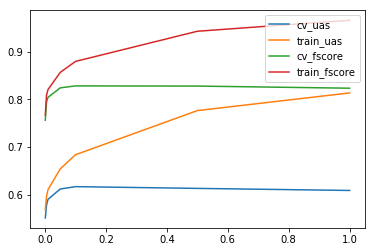

In [118]:
df_regularizations_results.index=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
df_regularizations_results[['cv_uas', 'train_uas', 'cv_fscore', 'train_fscore']].plot()
df_regularizations_results

Improvement by regularization (%):

In [114]:
round((1 - 0.6090058817857488/0.617009)*100, 2)

1.3

That's a nice improvement. Let's bound this value of *C* to the variable

In [115]:
C = 0.1

#### Try to add more features
I going to add the queue and stack sizes as features, and also remove unneeded features

In [116]:
def extract_features(stack, queue):
    features = {}
    if stack:
        features['s0form'] = stack[-1]['form']
        features['s0lemma'] = stack[-1]['lemma']
        features['s0pos'] = stack[-1]['upostag']
    if len(stack) > 1:
        features['s1pos'] = stack[-2]['upostag']
    if queue:
        features['q0form'] = queue[0]['form']
        features['q0lemma'] = queue[0]['lemma']
        features['q0pos'] = queue[0]['upostag']
    if len(queue) > 1:
        features['q1form'] = queue[1]['form']
        features['q1pos'] = queue[1]['upostag']
    if len(queue) > 2:
        features['q2pos'] = queue[2]['upostag']
    if len(queue) > 3:
        features['q3pos'] = queue[3]['upostag']
    if queue and stack:
        features['dist'] = queue[0]['id'] - stack[-1]['id']
    
    # NEW FEATURES GOES HERE 
    
    features['qsize'] = len(queue)
    features['ssize'] = len(stack)
        
    return features
ls2,fs2 = get_all_features(train)
cv_ls2, cv_fs2 = get_all_features(dev)

In [117]:
pipe = Pipeline([
    ('vectorizer', DictVectorizer()),
    ('classifier', LogisticRegression(C=C))
])
evaluate(pipe, fs2, ls2, train, cv_fs2, cv_ls2, dev)

Train results
precision:	0.8592812869707086
recall:		0.8576639895391428
fscore:		0.8574908085451468
UAS:		 0.659191989134198
CV results
precision:	0.8288201886063504
recall:		0.8274238077193742
fscore:		0.8271999653010502
UAS:		 0.6156590492720085


{'cv_fscore': 0.8271999653010502,
 'cv_precision': 0.8288201886063504,
 'cv_recall': 0.8274238077193742,
 'cv_uas': 0.6156590492720085,
 'train_fscore': 0.8574908085451468,
 'train_precision': 0.8592812869707086,
 'train_recall': 0.8576639895391428,
 'train_uas': 0.659191989134198}

For some reasong this feature configuration gives lower results by %: 

In [121]:
round((0.617009/0.6156590492720085 - 1)*100, 2)

0.22

#### Different solver and classifier
Let's try to use multinomial logistic regression with `newton-cg` solver with initial features set

In [122]:
pipe = Pipeline([
    ('vectorizer', DictVectorizer()),
    ('classifier', LogisticRegression(C=C, multi_class='multinomial', solver='newton-cg'))
])
evaluate(pipe, fs, ls, train, cv_fs, cv_ls, dev)

Train results
precision:	0.9042455870750743
recall:		0.9036531274842678
fscore:		0.9036124992290282
UAS:		 0.6535327172494607
CV results
precision:	0.8403307757299151
recall:		0.8388458831808585
fscore:		0.8386209527020534
UAS:		 0.6109343361295921


{'cv_fscore': 0.8386209527020534,
 'cv_precision': 0.8403307757299151,
 'cv_recall': 0.8388458831808585,
 'cv_uas': 0.6109343361295921,
 'train_fscore': 0.9036124992290282,
 'train_precision': 0.9042455870750743,
 'train_recall': 0.9036531274842678,
 'train_uas': 0.6535327172494607}

Add let's try with `libfgs` solver:

In [123]:
pipe = Pipeline([
    ('vectorizer', DictVectorizer()),
    ('classifier', LogisticRegression(C=C, multi_class='multinomial', solver='lbfgs'))
]) 
evaluate(pipe, fs, ls, train, cv_fs, cv_ls, dev)

Train results
precision:	0.8900309562444443
recall:		0.8895666322429178
fscore:		0.8894415257018949
UAS:		 0.6439585608138699
CV results
precision:	0.840222806917469
recall:		0.8393330807123911
fscore:		0.839009161934495
UAS:		 0.609198727220133


{'cv_fscore': 0.839009161934495,
 'cv_precision': 0.840222806917469,
 'cv_recall': 0.8393330807123911,
 'cv_uas': 0.609198727220133,
 'train_fscore': 0.8894415257018949,
 'train_precision': 0.8900309562444443,
 'train_recall': 0.8895666322429178,
 'train_uas': 0.6439585608138699}

In [124]:
pipe.fit(fs, ls)
print("Train results:")
print(classification_report(ls, pipe.predict(fs)))
tls, tfs = get_all_features(test)
print("Test results: ")
print(classification_report(tls, pipe.predict(tfs)))
print("Test uas: ", uas(test, pipe))

Train results:
             precision    recall  f1-score   support

   left_arc       0.87      0.92      0.90     34469
     reduce       0.92      0.86      0.89     32755
  right_arc       0.87      0.86      0.86     30675
      shift       0.90      0.91      0.91     36698

avg / total       0.89      0.89      0.89    134597

Test results: 
             precision    recall  f1-score   support

   left_arc       0.85      0.86      0.85      6270
     reduce       0.78      0.78      0.78      5957
  right_arc       0.78      0.75      0.76      5853
      shift       0.86      0.88      0.87      6709

avg / total       0.82      0.82      0.82     24789

Test uas:  0.5683111319365419


## Part 2

In [2]:
import tokenize_uk
import pymorphy2

morph = pymorphy2.MorphAnalyzer(lang='uk')

In [4]:
mapping = {"ADJF": "ADJ", "ADJS": "ADJ", "COMP": "ADJ", "PRTF": "ADJ",
           "PRTS": "ADJ", "GRND": "VERB", "NUMR": "NUM", "ADVB": "ADV",
           "NPRO": "PRON", "PNCT": "PUNCT", "PRED": "ADV", "PREP": "ADP",
           "PRCL": "PART"}

def normalize_pos(word):
    if word.tag.POS == "CONJ":
        if "coord" in word.tag:
            return "CCONJ"
        else:
            return "SCONJ"
    else:
        return mapping.get(word.tag.POS, word.tag.POS)

In [49]:
def convert_to_conllu_format(sent):
    tokens = tokenize_uk.tokenize_words(sent)
    pm_tokens = [morph.parse(word)[0] for word in tokens]
    dicts = []
    for i, token in enumerate(pm_tokens):
        dicts.append(collections.OrderedDict([('id', i+1),
                                              ('form', tokens[i]),
                                              ('lemma', token.normal_form),
                                              ('upostag', normalize_pos(token))]))
    return dicts
        


parse_tree(pipe, [convert_to_conllu_format("І як у кожній казці все закінчується добре")])

[[(4, 5), (3, 5), (2, 5), (5, 7), (1, 7), (7, 0), (8, 7)]]

['І', 'CCONJ', '7']
['як', 'PART', '5']
['у', 'ADP', '5']
['кожній', 'PRON', '5']
['казці', 'NOUN', '7']
['все', 'PRON', '0']
['закінчується', 'VERB', '0']
['добре', 'ADV', '7']


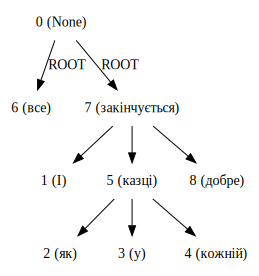

In [78]:
from nltk.parse.dependencygraph import DependencyGraph
import random
def parse_and_render(oracle, tree, verbose=False):
    deps = parse_tree(pipe, [tree], verbose)
    lines = []
    deps_map = dict(deps[0])
    for node in tree:
        parts = [node['form'], node['upostag'], str(deps_map.get(node['id'], 0))]
        print(parts)
        lines.append("\t".join(parts))
    return DependencyGraph(tree_str="\n".join(lines))
        
parse_and_render(pipe, convert_to_conllu_format("І як у кожній казці все закінчується добре"))

['А', 'CCONJ', '3']
['також', 'CCONJ', '3']
['врятувати', 'VERB', '0']
['від', 'ADP', '5']
['заторів', 'NOUN', '3']
['мешканців', 'NOUN', '3']
['лівого', 'ADJ', '3']
['берега', 'NOUN', '3']


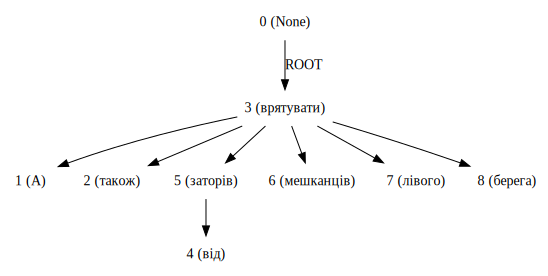

In [80]:
parse_and_render(pipe, convert_to_conllu_format("А також врятувати від заторів мешканців лівого берега"))

## Results

#### General
We see that regularization and different classifier gives us the most improvements over baseline on test set (**1.6%**). I think adding more example will make train error lower and then using regularization will give good results. Also changing the type of oracle (from static to dynamic) should give about 1-2% of improvements.

#### Results of parsing random sentences
We see parser has made some errors:
  * In the first example parser for some reasons calls reduce action on the word `все`. To handle it's better to add precondition to the reduce that the stack head has a parent. But I think this problem will be better resolved by using different type of oracle.
  * In the second example parser made error of wronly attaching nodes:
    * 6 must be a parent of 8
    * 8 must be a parent of 7
    This issues might e resolved by increasing size of train set.
  